<a href="https://colab.research.google.com/github/nellyiya/CHATBOT/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 2: Import libraries and load dataset

import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from Hugging Face Hub
dataset = load_dataset("KisanVaani/agriculture-qa-english-only", split='train')

print(f"Total samples in dataset: {len(dataset)}")
print(dataset[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22615 [00:00<?, ? examples/s]

Total samples in dataset: 22615
{'question': 'why is crop rotation important in farming?', 'answers': 'This helps to prevent soil erosion and depletion, and can also help to control pests and diseases'}


In [2]:
# Cell 3: Prepare train and validation splits using datasets library

split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_data = split_dataset['train']
val_data = split_dataset['test']

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Training samples: 18092
Validation samples: 4523


In [3]:
# Cell 4: Load tokenizer and define preprocessing

MODEL_NAME = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

MAX_LEN_INPUT = 64
MAX_LEN_OUTPUT = 64

def shift_tokens_right(input_ids, pad_token_id, decoder_start_token_id):
    shifted_input_ids = np.zeros_like(input_ids)
    shifted_input_ids[:, 0] = decoder_start_token_id
    shifted_input_ids[:, 1:] = input_ids[:, :-1]
    shifted_input_ids[input_ids == pad_token_id] = pad_token_id
    return shifted_input_ids.tolist()

def preprocess_function(examples):
    inputs = ["question: " + q for q in examples["question"]]
    targets = examples["answers"]  # or 'answer' based on your dataset
    model_inputs = tokenizer(inputs, max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")

    labels = tokenizer(targets, max_length=MAX_LEN_OUTPUT, truncation=True, padding="max_length")
    labels_ids = labels["input_ids"]

    labels_ids = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels_ids]
    model_inputs["labels"] = labels_ids

    decoder_input_ids = shift_tokens_right(
        np.array(labels["input_ids"]),
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    model_inputs["decoder_input_ids"] = decoder_input_ids

    return model_inputs

train_dataset = train_data.map(preprocess_function, batched=True)
val_dataset = val_data.map(preprocess_function, batched=True)

train_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
val_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/18092 [00:00<?, ? examples/s]

Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

In [4]:
# Cell 5: Convert Hugging Face datasets to tf.data.Dataset, including decoder_input_ids

def to_tf_dataset(hf_dataset):
    features = {
        "input_ids": np.array(hf_dataset["input_ids"]),
        "attention_mask": np.array(hf_dataset["attention_mask"]),
        "decoder_input_ids": np.array(hf_dataset["decoder_input_ids"]),
    }
    labels = np.array(hf_dataset["labels"])
    return tf.data.Dataset.from_tensor_slices((features, labels))

batch_size = 8  # Adjust this based on your CPU resources

tf_train_dataset = to_tf_dataset(train_dataset).shuffle(100).batch(batch_size)
tf_val_dataset = to_tf_dataset(val_dataset).batch(batch_size)

print("Training dataset batches:", tf_train_dataset)
print("Validation dataset batches:", tf_val_dataset)


Training dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>
Validation dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>


In [5]:
# Cell 6: Load model and compile

model = TFT5ForConditionalGeneration.from_pretrained(MODEL_NAME, from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

def masked_loss(y_true, y_pred):
    pad_token_id = tf.constant(tokenizer.pad_token_id, dtype=y_true.dtype)
    y_true_safe = tf.where(y_true == -100, pad_token_id, y_true)
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true_safe, y_pred, from_logits=True)
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


model.compile(optimizer=optimizer, loss=masked_loss)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
2262/2262 [==============================] - 310s 115ms/step - loss: 2.4952 - val_loss: 1.1993
Epoch 2/3
2262/2262 [==============================] - 258s 114ms/step - loss: 1.2515 - val_loss: 0.5209
Epoch 3/3
2262/2262 [==============================] - 258s 114ms/step - loss: 0.7179 - val_loss: 0.3446


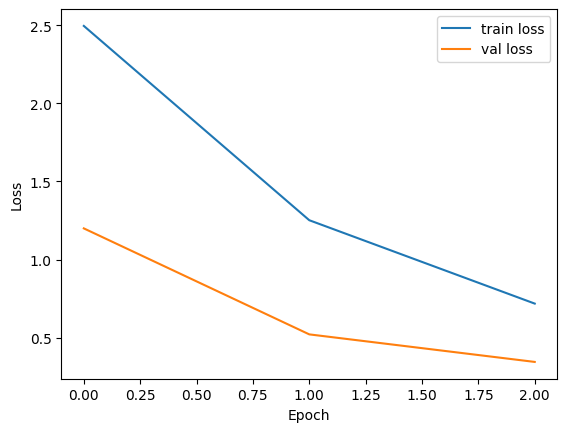

In [6]:
# Cell 7: Train model

epochs = 3

history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=epochs)

# Plot training/validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Cell 8: Save model and tokenizer

model.save_pretrained("./agri_chatbot_t5")
tokenizer.save_pretrained("./agri_chatbot_t5")


('./agri_chatbot_t5/tokenizer_config.json',
 './agri_chatbot_t5/special_tokens_map.json',
 './agri_chatbot_t5/spiece.model',
 './agri_chatbot_t5/added_tokens.json')

In [8]:
# Cell 9: Define inference function and test

def generate_answer(question, max_length=64):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="tf", max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

test_question = "what is organic farming?"
print("Q:", test_question)
print("A:", generate_answer(test_question))


Q: what is organic farming?
A: is the practice of growing crops in a variety of ways


In [13]:
%%writefile app.py
import streamlit as st
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

MODEL_PATH = "./agri_chatbot_t5"

@st.cache_resource
def load_model():
    tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)
    model = TFT5ForConditionalGeneration.from_pretrained(MODEL_PATH, from_pt=True)
    return tokenizer, model

tokenizer, model = load_model()

def generate_answer(question, max_length=64):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="tf", truncation=True, padding="max_length", max_length=64)
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

st.title("🌱 Agriculture Chatbot - T5")
st.write("Ask any question about agriculture and get accurate responses!")

user_input = st.text_input("Enter your question:")

if st.button("Get Answer"):
    if user_input.strip():
        answer = generate_answer(user_input)
        st.success(f"Answer: {answer}")
    else:
        st.warning("Please enter a valid question.")


Writing app.py


In [17]:
question = "what is fertilizers?"
answer = generate_answer(question)
print("Q:", question)
print("A:", answer)


Q: what is fertilizers?
A: Fertilizers are substances that are added to soil to improve the growth and quality of crops


In [23]:
import getpass
token = getpass.getpass('Enter your GitHub Personal Access Token: ')

repo_url = f"https://{token}@github.com/nellyiya/CHATBOT.git"

!git config --global user.email "n.iyabikoze@alustudent.com"
!git config --global user.name "nellyiya"

!git clone {repo_url}
%cd CHATBOT


Enter your GitHub Personal Access Token: ··········
Cloning into 'CHATBOT'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 103.17 KiB | 5.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/CHATBOT/CHATBOT/CHATBOT


In [24]:
# Install git lfs if not already installed
!git lfs install

# Track .h5 and other large files in your model folder
!git lfs track "agri_chatbot_t5/*.h5"
!git lfs track "agri_chatbot_t5/*.bin"
!git add .gitattributes
!git commit -m "Add git-lfs tracking for large model files"


Updated git hooks.
Git LFS initialized.
Tracking "agri_chatbot_t5/*.h5"
Tracking "agri_chatbot_t5/*.bin"
[main 91f15c4] Add git-lfs tracking for large model files
 1 file changed, 2 insertions(+)
 create mode 100644 .gitattributes


In [28]:
!ls


agri_chatbot_t5  app.py  README.md


In [29]:

!cp -r /content/agri_chatbot_t5 .
!cp /content/app.py .


In [30]:
!git add .
!git commit -m ", model (LFS), and Streamlit UI"
!git push origin main


[main 803aca5] , model (LFS), and Streamlit UI
 8 files changed, 1267 insertions(+)
 create mode 100644 agri_chatbot_t5/added_tokens.json
 create mode 100644 agri_chatbot_t5/config.json
 create mode 100644 agri_chatbot_t5/generation_config.json
 create mode 100644 agri_chatbot_t5/special_tokens_map.json
 create mode 100644 agri_chatbot_t5/spiece.model
 create mode 100644 agri_chatbot_t5/tf_model.h5
 create mode 100644 agri_chatbot_t5/tokenizer_config.json
 create mode 100644 app.py
Uploading LFS objects: 100% (1/1), 374 MB | 41 MB/s, done.
Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 2 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 406.63 KiB | 5.42 MiB/s, done.
Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), done.
To https://github.com/nellyiya/CHATBOT.git
   f7ba959..803aca5  main -> main
